# Import Relevant Libraries and Create generated_images folder

In [46]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Create directory to save generated images
os.makedirs("generated_images", exist_ok=True)

# Define model hyperparameters

In [47]:
LATENT_DIM = 20  # Latent space size
INPUT_DIM = 784  # Flattened MNIST images (28x28)
BATCH_SIZE = 200
NUM_EPOCHS = 50

# Load MNIST dataset

In [59]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()
train_images = train_images.astype("float32") / 255.0  # Normalize to [0,1]
test_images = test_images.astype("float32") / 255.0

# Mask the right hald of the images

In [49]:
# Function to mask the right half of an image
def mask_right_half(images):
    images = images.copy()
    images[:, :, 14:] = 0  # Set right half (columns 14-27) to black (0)
    return images

# Mask training images before feeding them into the encoder
masked_train_images = mask_right_half(train_images).reshape(-1, INPUT_DIM)
train_images = train_images.reshape(-1, INPUT_DIM)  # Keep original images for MSE computation

# Create dataset with masked images as input and original images as target
masked_dataset = tf.data.Dataset.from_tensor_slices((masked_train_images, train_images)).shuffle(60000).batch(BATCH_SIZE)

# Encoder model

In [50]:
def build_encoder():
    inputs = keras.Input(shape=(INPUT_DIM,))
    x = layers.Dense(196, activation="relu")(inputs)
    x = layers.Dense(98, activation="relu")(x)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(25, activation="relu")(x)
    z = layers.Dense(LATENT_DIM)(x)
    return keras.Model(inputs, z, name="Encoder")

# Decoder model

In [51]:
def build_decoder():
    inputs = keras.Input(shape=(LATENT_DIM,))
    x = layers.Dense(25, activation="relu")(inputs)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(98, activation="relu")(x)
    x = layers.Dense(196, activation="relu")(x)
    outputs = layers.Dense(INPUT_DIM, activation="sigmoid")(x)  # Output in range [0,1]
    return keras.Model(inputs, outputs, name="Decoder")

# Discriminator model

In [52]:
def build_discriminator():
    inputs = keras.Input(shape=(INPUT_DIM,))
    x = layers.Dense(196, activation="relu")(inputs)
    x = layers.Dense(98, activation="relu")(x)
    x = layers.Dense(50, activation="relu")(x)
    x = layers.Dense(25, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    return keras.Model(inputs, outputs, name="Discriminator")

# Optimization Algorithm and Loss Function

In [53]:
# Instantiate models
encoder = build_encoder()
decoder = build_decoder()
discriminator = build_discriminator()

# Optimizers
ae_optimizer = keras.optimizers.Adam(learning_rate=0.001)
d_optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Loss functions
reconstruction_loss_fn = keras.losses.MeanSquaredError()
adv_loss_fn = keras.losses.BinaryCrossentropy(reduction="sum")

# Model Summary
encoder.summary()
decoder.summary()
discriminator.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 50)             │         4,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 20)             │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,911 (702.78 KB)

 Trainable params: 179,911 (702.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 25)             │           525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 50)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 98)             │         4,998 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 196)            │        19,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 784)            │       154,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,675 (705.76 KB)

 Trainable params: 180,675 (705.76 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 50)             │         4,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,417 (700.85 KB)

 Trainable params: 179,417 (700.85 KB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

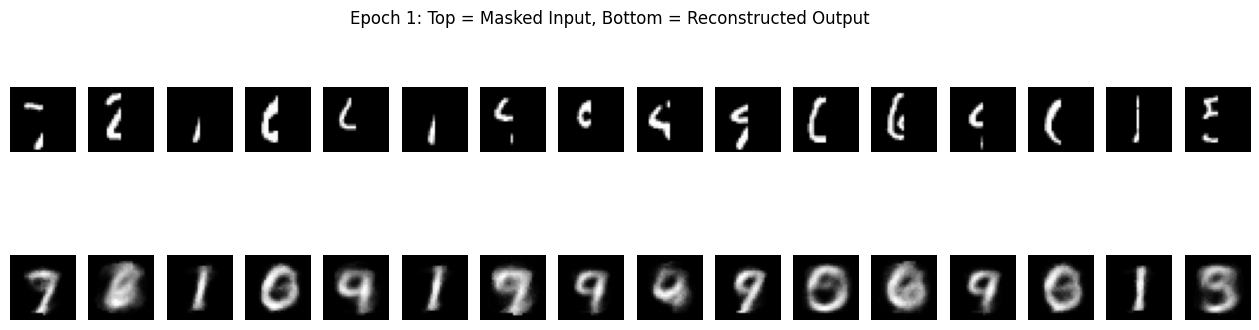

Epoch 1/50, AE Loss: 0.0458, D Loss: 3.8315
Epoch 2/50, AE Loss: 0.0347, D Loss: 8.0743
Epoch 3/50, AE Loss: 0.0322, D Loss: 2.8127
Epoch 4/50, AE Loss: 0.0281, D Loss: 7.3137
Epoch 5/50, AE Loss: 0.0280, D Loss: 5.8043


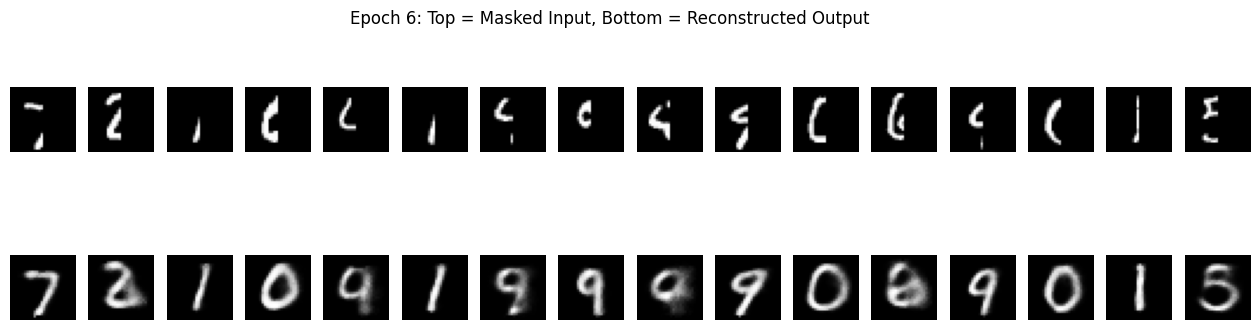

Epoch 6/50, AE Loss: 0.0277, D Loss: 2.8229
Epoch 7/50, AE Loss: 0.0270, D Loss: 1.7296
Epoch 8/50, AE Loss: 0.0255, D Loss: 4.9034
Epoch 9/50, AE Loss: 0.0246, D Loss: 8.7498
Epoch 10/50, AE Loss: 0.0241, D Loss: 2.2411


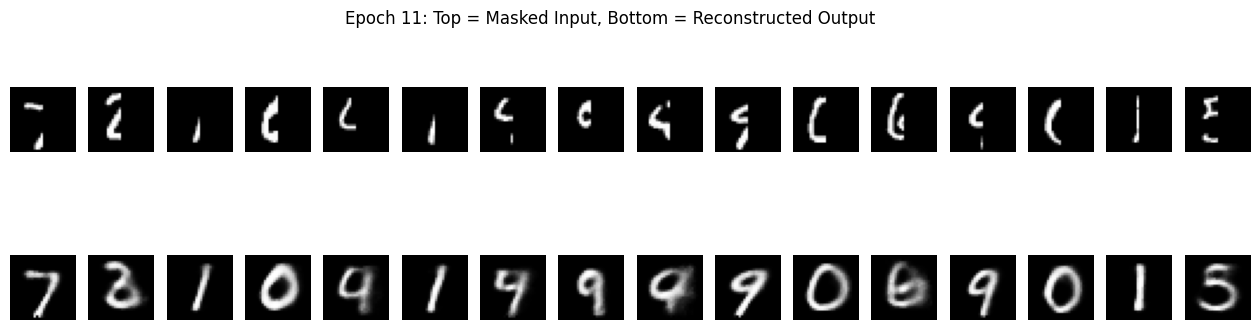

Epoch 11/50, AE Loss: 0.0246, D Loss: 2.3132
Epoch 12/50, AE Loss: 0.0239, D Loss: 1.3543
Epoch 13/50, AE Loss: 0.0230, D Loss: 4.2548
Epoch 14/50, AE Loss: 0.0239, D Loss: 1.5823
Epoch 15/50, AE Loss: 0.0244, D Loss: 6.4392


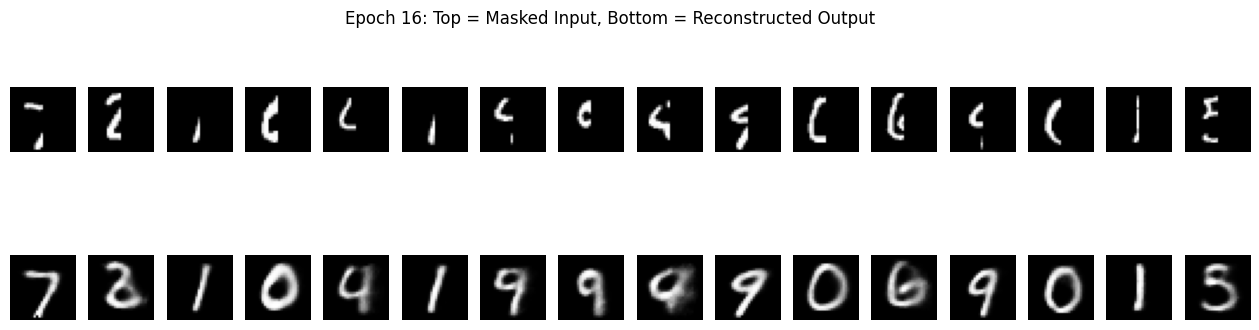

Epoch 16/50, AE Loss: 0.0226, D Loss: 2.5171
Epoch 17/50, AE Loss: 0.0233, D Loss: 0.4890
Epoch 18/50, AE Loss: 0.0224, D Loss: 1.1503
Epoch 19/50, AE Loss: 0.0231, D Loss: 6.7504
Epoch 20/50, AE Loss: 0.0228, D Loss: 2.0918


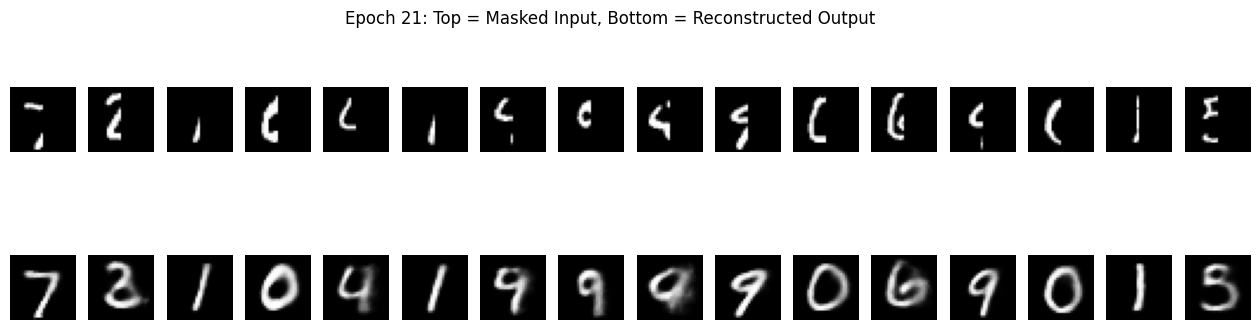

Epoch 21/50, AE Loss: 0.0225, D Loss: 1.4360
Epoch 22/50, AE Loss: 0.0209, D Loss: 1.8256
Epoch 23/50, AE Loss: 0.0200, D Loss: 1.0692
Epoch 24/50, AE Loss: 0.0212, D Loss: 0.4160
Epoch 25/50, AE Loss: 0.0218, D Loss: 1.1568


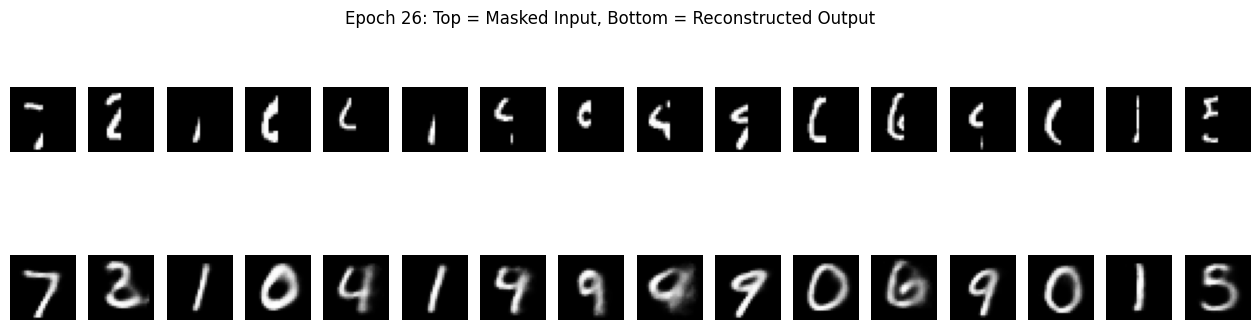

Epoch 26/50, AE Loss: 0.0203, D Loss: 3.4770
Epoch 27/50, AE Loss: 0.0194, D Loss: 3.7103
Epoch 28/50, AE Loss: 0.0210, D Loss: 2.2690
Epoch 29/50, AE Loss: 0.0205, D Loss: 0.0613
Epoch 30/50, AE Loss: 0.0205, D Loss: 1.5497


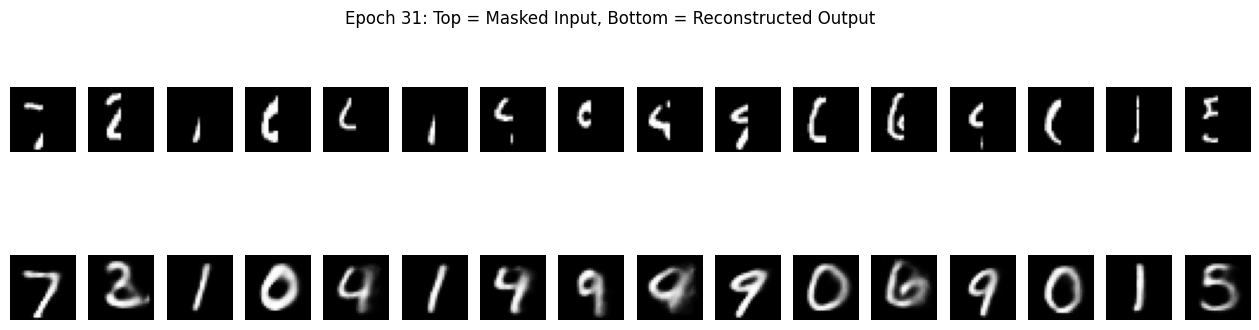

Epoch 31/50, AE Loss: 0.0199, D Loss: 1.4724
Epoch 32/50, AE Loss: 0.0194, D Loss: 0.5360
Epoch 33/50, AE Loss: 0.0209, D Loss: 5.4776
Epoch 34/50, AE Loss: 0.0189, D Loss: 5.4507
Epoch 35/50, AE Loss: 0.0202, D Loss: 0.5608


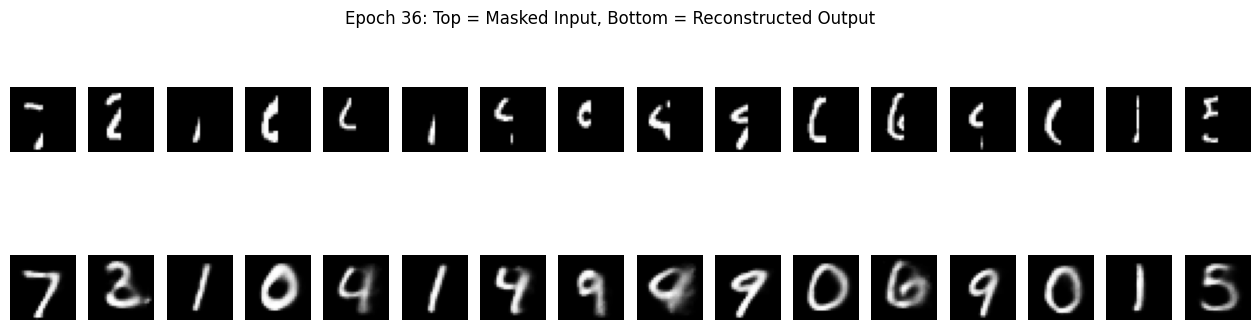

Epoch 36/50, AE Loss: 0.0198, D Loss: 0.2480
Epoch 37/50, AE Loss: 0.0201, D Loss: 5.3622
Epoch 38/50, AE Loss: 0.0178, D Loss: 2.5569
Epoch 39/50, AE Loss: 0.0194, D Loss: 0.2364
Epoch 40/50, AE Loss: 0.0190, D Loss: 4.7212


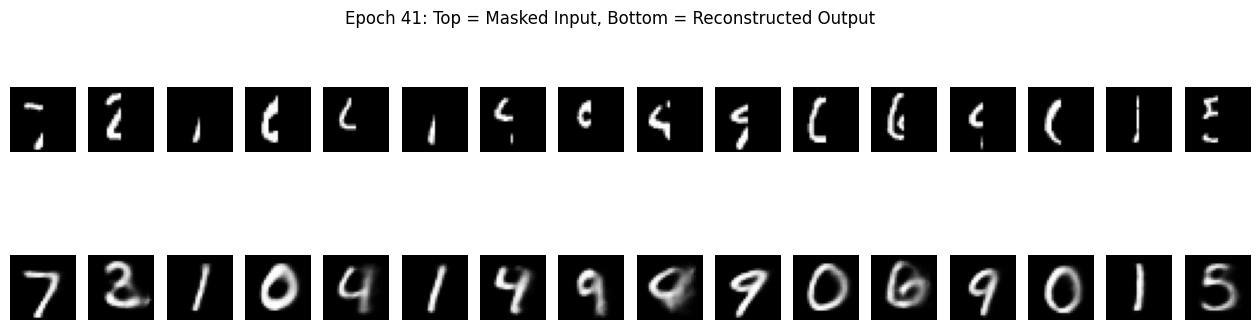

Epoch 41/50, AE Loss: 0.0198, D Loss: 0.8959
Epoch 42/50, AE Loss: 0.0212, D Loss: 0.4530
Epoch 43/50, AE Loss: 0.0188, D Loss: 3.8130
Epoch 44/50, AE Loss: 0.0199, D Loss: 1.8185
Epoch 45/50, AE Loss: 0.0188, D Loss: 0.5680


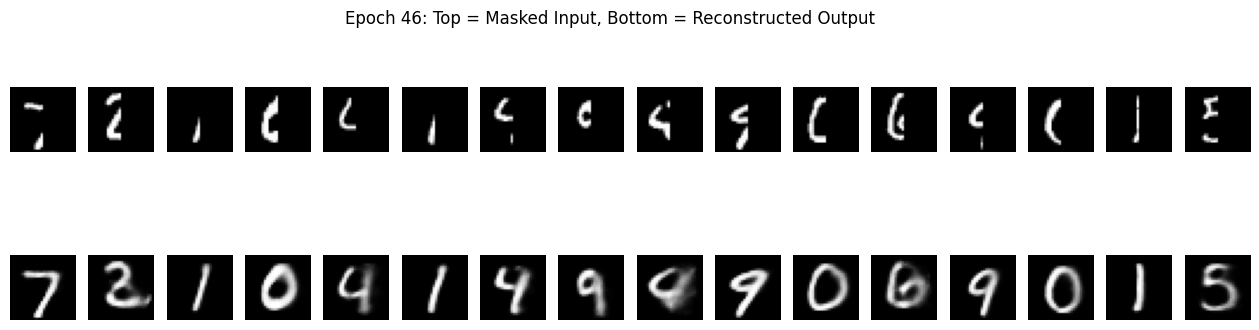

Epoch 46/50, AE Loss: 0.0196, D Loss: 0.0180
Epoch 47/50, AE Loss: 0.0193, D Loss: 0.3143
Epoch 48/50, AE Loss: 0.0189, D Loss: 3.3037
Epoch 49/50, AE Loss: 0.0189, D Loss: 1.1535
Epoch 50/50, AE Loss: 0.0186, D Loss: 0.7039


In [54]:
# Training loop
start_training_time = time.time()

for epoch in range(NUM_EPOCHS):
    for masked_batch, original_batch in masked_dataset:
        # Autoencoder step
        with tf.GradientTape() as tape:
            z = encoder(masked_batch)  # Feed masked images
            x_recon = decoder(z)  # Predict full image
            loss_ae = reconstruction_loss_fn(original_batch, x_recon)  # Compare with original
        grads = tape.gradient(loss_ae, encoder.trainable_variables + decoder.trainable_variables)
        ae_optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))

        # Discriminator step
        real_labels = tf.ones((masked_batch.shape[0], 1))
        fake_labels = tf.zeros((masked_batch.shape[0], 1))
        
        with tf.GradientTape() as tape:
            d_real = discriminator(original_batch)
            d_fake = discriminator(x_recon)
            loss_d = adv_loss_fn(real_labels, d_real) + adv_loss_fn(fake_labels, d_fake)
        grads = tape.gradient(loss_d, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Save generated images every 5 epochs
    if epoch % 5 == 0:
        # Select sample images
        sample_masked_imgs = mask_right_half(test_images[:16])  # Masked input
        sample_masked_imgs_flat = sample_masked_imgs.reshape(-1, INPUT_DIM)
    
        # Generate images from autoencoder
        sample_z = encoder(sample_masked_imgs_flat, training=False)
        generated_images = decoder(sample_z, training=False).numpy().reshape(16, 28, 28)
    
        # Plot both masked input and reconstructed output
        fig, axes = plt.subplots(2, 16, figsize=(16, 4))  # 2 rows, 16 columns
    
        for i in range(16):
            # Show masked input in first row
            axes[0, i].imshow(sample_masked_imgs[i], cmap='gray')
            axes[0, i].axis('off')
    
            # Show reconstructed output in second row
            axes[1, i].imshow(generated_images[i], cmap='gray')
            axes[1, i].axis('off')
        plt.suptitle(f"Epoch {epoch+1}: Top = Masked Input, Bottom = Reconstructed Output")
        plt.savefig(f"generated_images/epoch_{epoch+1}.png")  # Save as PNG
        plt.show()  # Display the images
        plt.close()

        

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, AE Loss: {loss_ae:.4f}, D Loss: {loss_d:.4f}")

training_time = time.time() - start_training_time

# Evaluate the trained model

In [77]:
# Mask right half and reshape for evaluation
sample_masked_test = mask_right_half(test_images[:1000]).reshape(-1, INPUT_DIM)
sample_test_images = test_images[:1000].reshape(-1, INPUT_DIM)
adv_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction="sum")

# Start inference time tracking
start_inference_time = time.time()

# Encode and decode
sample_z = encoder(sample_masked_test, training=False)
generated_images = decoder(sample_z, training=False).numpy().reshape(-1, INPUT_DIM)

# Compute inference time
inference_time = time.time() - start_inference_time

# Compute Mean Squared Error (MSE) loss
mse_loss = reconstruction_loss_fn(sample_test_images, generated_images).numpy()

# Compute Binary Cross-Entropy (BCE) Loss
real_labels = tf.ones((sample_masked_test.shape[0], 1))
fake_labels = tf.zeros((sample_masked_test.shape[0], 1))

d_real = discriminator(sample_test_images)
d_fake = discriminator(generated_images)

bce_loss = adv_loss_fn(real_labels, d_real) + adv_loss_fn(fake_labels, d_fake)

# Compute Classification Error
real_preds = discriminator(sample_test_images, training=False)
fake_preds = discriminator(generated_images, training=False)

real_acc = tf.reduce_mean(tf.cast(real_preds > 0.5, tf.float32))
fake_acc = tf.reduce_mean(tf.cast(fake_preds < 0.5, tf.float32))
classification_error = 1.0 - (real_acc + fake_acc) / 2

# Log-Likelihood Approximation
z_mean = tf.reduce_mean(sample_z, axis=0)
z_var = tf.math.reduce_variance(sample_z, axis=0)
log_likelihood = -0.5 * tf.reduce_sum((sample_z - z_mean) ** 2 / (z_var + 1e-8) + tf.math.log(2 * np.pi * (z_var + 1e-8)))

# Display the results

In [79]:
# Print results
print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.4f}s")
print(f"Final MSE Loss: {mse_loss:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Classification Error: {classification_error:.4f}")
print(f"Log-Likelihood (approx.): {log_likelihood:.4f}")

Training Time: 2400.66 seconds
Inference Time: 0.0160s
Final MSE Loss: 0.0207
BCE Loss: 1.9069
Classification Error: 0.0000
Log-Likelihood (approx.): -47457.8633
